# Machine Learning Parte II - Aprendizaje No Supervisado

## Clustering

El *clustering* como su nombre lo indica es el agrupamiento de datos.

En otras palabras: Es clasificar objetos en diferentes grupos, de manera que objetos *similares* o que *tengan algo en común* sean agrupados en el mismo grupo.

Si bien, existen numerosos algoritmos de clustering, todos, aunque de distintas formas, todos todos todos! van a intentar crear grupos (*clusters*) a partir de los datos, de manera que los más *parecidos* en base a una o más aracterísticas queden juntos. Por lo tanto, el primer paso para agrupar es encontrar en el conjunto de datos la o las **características** que sean más informativas para agruparlos.


En la siguiente figura, se muestran los distintos algoritmos de clustering que se encuentran en scikit-learn (para una mayor descripción del módulo visiten [scikit-clustering](https://scikit-learn.org/stable/modules/clustering.html)).

Cada columna es la salida de un algoritmo de clustering diferente. Todos los algoritmos fueron entrenados con el mismo conjunto de datos.

Algunos algoritmos tienen la misma salida. Sin embargo, otros dieron resultados diferentes, dos grupos (naranja y azul) o tres grupos (naranja, azul y verde).

No hay una respuesta correcta o incorrecta en clustering. En este caso, no es tan simple de determinar el agrupamiento y decir “X algoritmo funciona mejor para este caso.”

En este caso, que algoritmo funciona mejor no depende en una métrica sino más bien en la interpretación y utilidad de la salida para el caso de estudio.

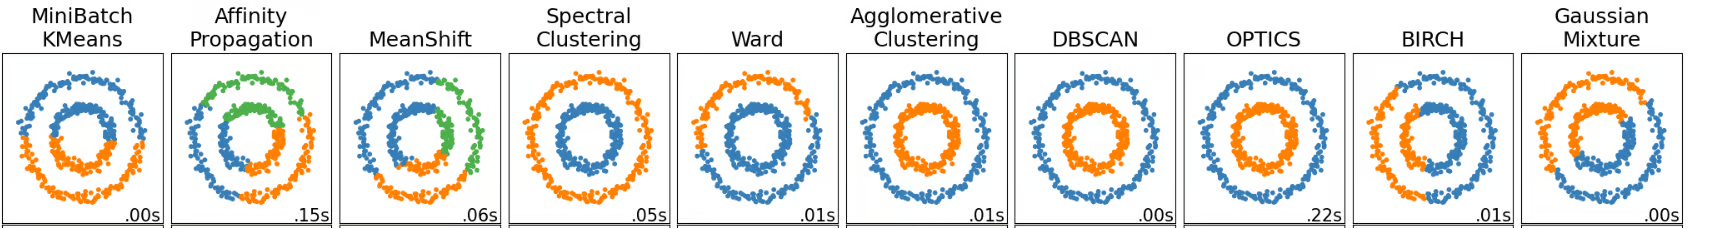

### Tipos de Clustering

Hay dos tipos de *clustering*: Jerárquico y Particional

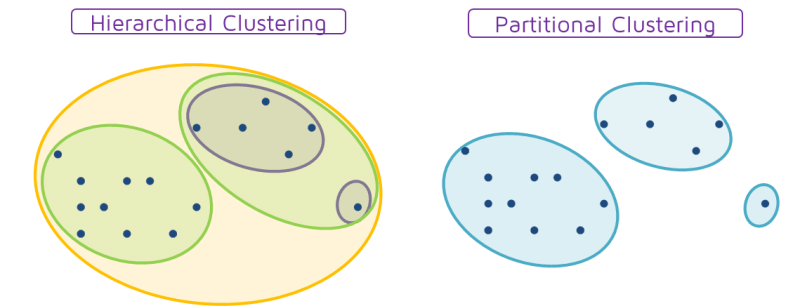

#### **Clustering jerárquico:**

* Se agrupa en una jerarquía anidada.
* En general se representa como dendrograma
* Es costoso computacionalmente


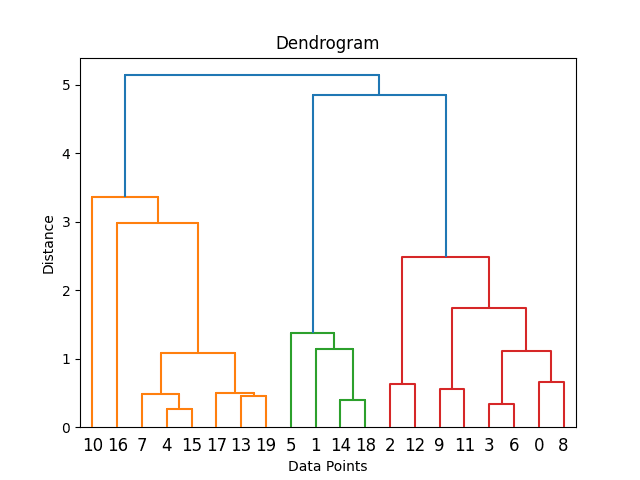

#### **Clustering Particional:**

* Se obtiene una partición de clústers
* Menos costoso

En este curso vamos a ver el método de K-Means, que es particional.

### KMeans

* Como parámetro necesita el número de clusters a estimar.

* Para agrupar usa la distancia euclídeana.

* Sensible a outliers

* Es rápido.

Kmeans utiliza un método iterativo para asignar directamente cada elemento a diferentes grupos.

Crea clusters sin solapamiento, es decir, cada elemento puede pertener a un único cluster.

Con el número de cluster definidos, el algoritmo inicializa centroides al azar.
Luego, se calcula la distancia entre cada uno de los datos a cada centroide y se asigna cada dato al centroide más cercano.

Luego, se calcula la media en base a todos los puntos asignado, y por ende cambia la posición del centroide.

Se reasignan los datos al centroide más cercano y así hasta que converge, es decir, hasta que no cambia la media (o hasta que alcanza un número de iteraciones definido por el usuario, que en scikit learn es 300 por defecto).


#### Silhouette

Para cada elemento presente en un *cluster* se puede calcular un **Silhouette coeficient**.

 **Silhouette coeficient.** Es un número entre -1 y 1 que indica que tan **similar** es el *elemento x* a otros elementos de su mismo cluster y que tan **diferente** es dicho elemento a los elementos de otros clusters.

$$
s(\vec{x_i}) = \frac{\vec{b(x_i)}-\vec{a(x_i)}}{\text{max}\left[\vec{b(x_i)},\vec{a(x_i)}\right]}
$$


$a(\vec{x_i})$ = distancia promedio de $\vec{x_i}$ a otros elementos en el cluster. Cuanto menor sea este valor mejor ubicado en el cluster está.

$b(\vec{x_i})$ = distancia promedio de $\vec{x_i}$ a otros elementos del cluster más cercano. Cuanto mayor sea este valor menos parecido es a elementos de otro cluster.

* Si $b(\vec{x_i})$ > $a(\vec{x_i})$ entonces $s(\vec{x_i}) \rightarrow 1$, elemento está bien agrupado.

* Si $b(\vec{x_i})$ < $a(\vec{x_i})$ entonces $s(\vec{x_i}) \rightarrow -1$, elemento está mal agrupado.

* Si $b(\vec{x_i})$ = $a(\vec{x_i})$ entonces $s(\vec{x_i}) \rightarrow 0$, elemento da igual en qué cluster esté.

* Nota: Arbitrariamente, si el cluster tiene un único elemento, $s(\vec{x_i}) = 0$

En resumen, cuanto más cerca de 1 esté $s(\vec{x_i}), mejor asignado esta dicho elemento en su cluster (más parecido a los de su cluster y menos a los de otros cluster).

El **Silhouette coefficient promedio** de todos los elementos de un cluster si es cercano a 1 indica que el agrupamiento general es mejor.



$$
S = \frac{1}{k} \left(\frac{1}{|c_{k}|}\sum\limits_{\vec{x_i}\ \in\ c_k}\frac{b(\vec{x_i}) - a(\vec{x_i})}{\text{max} \left[ b(\vec{x_i}),a(\vec{x_i}) \right]}
\right)
$$

donde:

$k$ = número de clusters?

$|c_{k}|$ = número de elementos en el cluster *k*

### Actividad Nro 1

Utilizaremos el mismo set de compuestos que atraviesan o no la barrera hematoencefálica.



In [209]:
# @title Instalación de librerías necesarias para quimioinformática

!pip install rdkit useful_rdkit_utils

In [210]:
# @title Instalación de librerías necesarias para machine learning

!pip install scikit-learn

In [211]:
# @title Instalación de librerías necesarias para graficar

!pip install seaborn matplotlib

In [212]:
# @title Descargando bases de datos y leyendo con pandas

import pandas as pd

try:
    bbb = pd.read_csv("https://raw.githubusercontent.com/sebastianjinich/material_tps_bioinfo/main/BBB-dataset.csv")
    print("Se cargó la base de datos de BBB en la variable bbb")
except:
    print("No se descargó la db de BBB")

print(bbb.head(5))

Se cargó la base de datos de BBB en la variable bbb
                                   SMILES BBB
0                     CCCCNC(=S)Nc1ccccc1   +
1             CCCCCCN1CCN(CC1)c1ccc(I)cc1   +
2  OCc1nnc2CN=C(c3ccccc3)c3cc(Cl)ccc3-n12   -
3             CC(C)CN1CCN(CC1)c1ccc(I)cc1   +
4                                  CCCCCO   +


In [213]:
# @title Validación de Smiles
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

SMILES = [] # Creo una lista vacía donde voy a guardar los smiles que funcionan bien
positive_negative = [] # Creo una lista vacía donde voy a guardar si es positivo o negativo
for i in range(len(bbb['SMILES'])): # Itero por la columna smiles
  try:
    # Intento canonicalizar el string del smiles, es decir, convertirlo a
    # una representación estándar única. Si el smiles es válido, lo guardo, en
    # la lista SMILES, y el IC50 en la lista smiles.
    cs = Chem.CanonSmiles(bbb['SMILES'][i])
    SMILES.append(cs)
    positive_negative.append(bbb['BBB'][i])
  except:
    # Si el smiles es inválido, lo imprimo
    print('Invalid SMILES:', bbb['SMILES'][i],i)

print('Loop Ended')

df = pd.DataFrame(list(zip(SMILES, positive_negative)),
               columns =['SMILES', 'BBB'])
print(df.head(5))

Loop Ended
                                   SMILES BBB
0                     CCCCNC(=S)Nc1ccccc1   +
1             CCCCCCN1CCN(c2ccc(I)cc2)CC1   +
2  OCc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2   -
3             CC(C)CN1CCN(c2ccc(I)cc2)CC1   +
4                                  CCCCCO   +


In [214]:
# @title Calculo los descriptores

logPs_bbb = []
tpsas_bbb = []

for index, row in bbb.iterrows():
    smile = row['SMILES']
    molecula = Chem.MolFromSmiles(smile)
    logPs_bbb.append(Descriptors.MolLogP(molecula))
    tpsas_bbb.append(Descriptors.TPSA(molecula,includeSandP = True))

df['logP'] = logPs_bbb
df['TPSA'] = tpsas_bbb


In [215]:
# @title Aplico K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X= df[['logP','TPSA']]
numero_clusters = 2

# Instancio StandardScaler.
scaler = StandardScaler()
# Transformo los datos
X = scaler.fit_transform(X)

# Instancio el algoritmo
kmeans = KMeans(n_clusters = numero_clusters, random_state = 0, n_init='auto')
# Fiteo el algoritmo
kmeans.fit(X)
# Aplico
cluster_labels = kmeans.predict(X)

# Guardo las etiquetas de clusters
df['labels'] = cluster_labels

In [216]:
# @title Calculo del índice de Sillhouette

from sklearn.metrics import silhouette_samples, silhouette_score

# Score del clustering general
score = silhouette_score(X, cluster_labels, random_state=0)
print(f'S = {round(score,2)}')

# Score de cada uno de los datos
sample_silhouette_values = silhouette_samples(X, cluster_labels)

cluster_scores = []

for label in range(numero_clusters):
  ith_cluster_score = sample_silhouette_values[cluster_labels == label].mean()
  cluster_scores.append(ith_cluster_score)
  print(f'S{label} = {round(ith_cluster_score,2)}')

S = 0.44
S0 = 0.38
S1 = 0.46


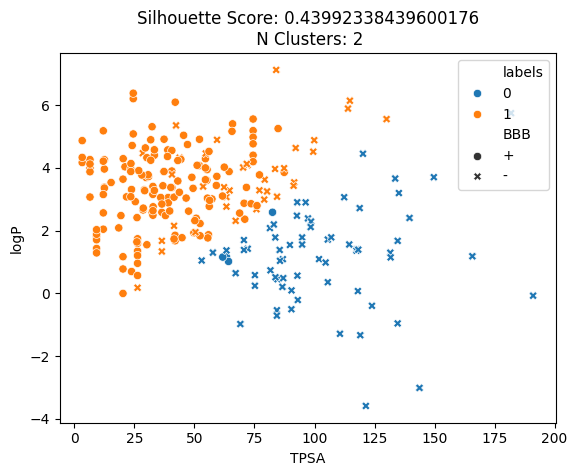

In [217]:
# @title Grafico el resultado
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data = df, x = 'TPSA', y = 'logP', hue = 'labels',style='BBB')
plt.title(f'Silhouette Score: {score}\n N Clusters: 2')
plt.show()

En este caso, fue fácil elegir el número de clusters porque ya conocíamos los datos!

Pero, ¿Cómo elegimos el número de cluster "mejor" cuando no se sabe si existe una estructura alguna de los datos?

Esto se hace, calculando el Índice de Silhouette para distinto número de clusters.

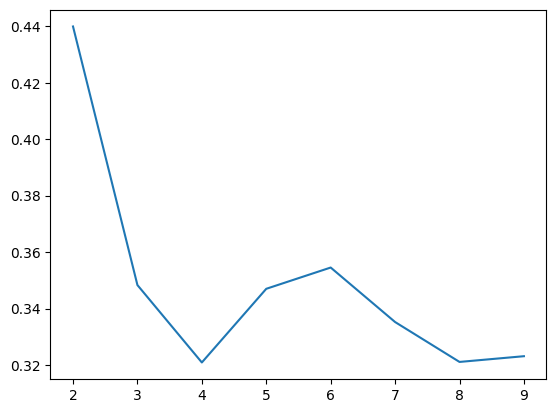

In [218]:
# @title Elección del número de clusters
from sklearn.metrics import silhouette_score

silhouettes = []
for i in range(2,10):
    kmeans = KMeans(n_clusters = i, random_state = 0, n_init='auto')
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_, random_state=0)
    silhouettes.append(score)

sns.lineplot(x = range(2,10), y = sillouettes)
plt.show()

Otra forma de elegir el número de clusters es con Inertia. K-means intenta apunta a elegir los centroides que minimizan la *inertia*:

$$
\sum \limits_{i=0}^n (||x_i - C_j||^2)
$$

Calcula la distancia cuadrada de cada muestra en un cluster al centroide y las suma.

Es una medida de cuan coherentes son los clusters internamente.

Problema, no es una métrica normalizada, sólo sabemos que un valor bajo es mejor y que cero es el óptimo.

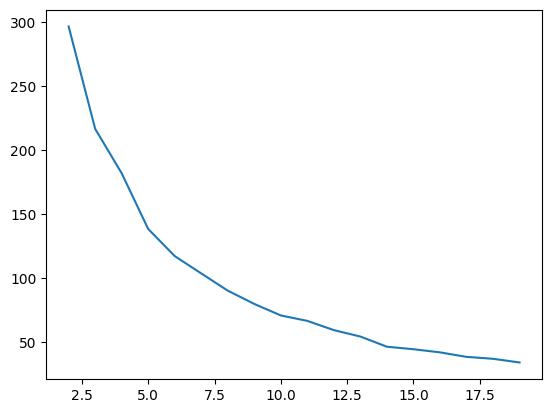

In [219]:
# @title Elección del número de clusters
from sklearn.metrics import silhouette_score

inertias = []
for i in range(2,20):
    kmeans = KMeans(n_clusters = i, random_state = 0, n_init='auto')
    kmeans.fit(X)
    score = kmeans.inertia_
    inertias.append(score)

sns.lineplot(x = range(2,20), y = inertias)
plt.show()

## Actividad Nro 2

Se parte de un dataset de pequeñas moléculas obtenidas de la base de datos ChEMBL. Este conjunto de datos está formado por 274 pequeñas moléculas de las cuales tenemos su ID de ChEMBL, su nombre, y la molécula en formato SMILES.

In [220]:
# @title Instalación de las librerías necesarias

# Escriba aquí su código

In [221]:
# @title Importación de las librerías necesarias

# Escriba aquí su código

In [222]:
# @title Cargamos los datos
url = 'https://raw.githubusercontent.com/mvillacampafdez/Chemoinf_july23/main/compounds_unique.csv'

datos = pd.read_csv(url)

In [223]:
# @title Evaluación de Smiles

valid = [] # Creo una lista vacía donde voy a guardar 1 o 0 según si los smiles funcionan bien o no

for i in range(len(datos['Smiles'])): # Itero por la columna smiles
  try:
    # Intento canonicalizar el string del smiles, es decir, convertirlo a
    # una representación estándar única.
    # Si el smiles es válido, guardo un 1 en valid, si no un 0
    cs = Chem.CanonSmiles(datos['Smiles'][i])
    valid.append(1)
  except:
    # Si el smiles es inválido, lo imprimo
    print('Invalid SMILES:', datos['Smiles'][i],i)
    valid.append(0)

print('Loop Ended')
if(sum(valid) == datos.shape[0]):
  print('Todos los SMILES son válidos')

Loop Ended
Todos los SMILES son válidos


In [224]:
# @title Obtención de descriptores
# molecules from smiles
ms = [Chem.MolFromSmiles(smile) for smile in datos['Smiles']]
# number of atoms per molecule
numb = [mol.GetNumAtoms() for mol in ms]
# different atoms:
C = [] # carbon
O = [] # oxigen
N = [] # nitrogen
for mol in ms:
  c = 0
  o = 0
  n = 0
  for atom in mol.GetAtoms():
    if atom.GetAtomicNum() == 6:
      c += 1
    if atom.GetAtomicNum() == 7:
      n += 1
    if atom.GetAtomicNum() == 8:
      o += 1
  C.append(c)
  O.append(o)
  N.append(n)
# molecular weight
MolWeight = [Descriptors.ExactMolWt(mol) for mol in ms]
# rings
Rings = [Descriptors.RingCount(mol) for mol in ms]
# Total polar surface area
TPSA = [Descriptors.TPSA(mol) for mol in ms]
# Density Morgan FP
FpDM1 = [Descriptors.FpDensityMorgan1(mol) for mol in ms]
# rotatable bonds
RotBonds = [Descriptors.NumRotatableBonds(mol) for mol in ms]

descriptors_df = pd.DataFrame(list(zip(numb, C, O, N, MolWeight, Rings, TPSA, FpDM1, RotBonds)))
descriptors_df.columns = ['Numero_atomos', "C","O","N","MolWeight", "Rings", "TPSA", "FpDM1", "RotBonds"]
descriptors_df

,Numero_atomos,C,O,N,MolWeight,Rings,TPSA,FpDM1,RotBonds
0,30,27,3,0,406.250795,5,43.37,1.033333,4
1,57,43,11,3,785.352359,6,198.38,0.982456,2
2,21,20,1,0,286.229666,1,20.23,1.190476,5
3,27,22,5,0,382.271924,1,83.83,1.259259,13
4,25,18,3,3,367.166269,3,76.82,1.480000,6
...,...,...,...,...,...,...,...,...,...
269,38,25,3,6,546.139401,4,142.17,1.131579,8
270,29,27,2,0,400.334131,3,40.46,1.137931,6
271,7,0,4,0,141.940784,0,83.42,1.285714,0
272,2,0,0,0,41.988172,0,0.00,1.000000,0


In [225]:
# @title Estandarización de datos
from sklearn.preprocessing import MaxAbsScaler



In [226]:
# @title Utiliza Kmeans para determinar el número de Clusters con el silhouette score y con inertia

from sklearn.cluster import KMeans

n_cluster = 12

silhouettes = []
inertias = []

for i in range(2,n_cluster):
  # COMPLETAR

SyntaxError: incomplete input (<ipython-input-226-4285971>, line 11)

In [ ]:
# @title Grafica ambas métricas (en gráficos separados)



¿Qué modelo seleccionarías?

In [ ]:
#@title Armado del modelo

# ESCRIBRE TU CÓDIGO AQUÍ

# Machine Learning Parte II - Aprendizaje Supervisado


## Neural Networks (Deep Learning)

Las redes neuronales son modelos computacionales inspirados en las estructuras de las neuronas interconectadas.

Son una serie de algoritmos diseñados para reconocer patrones y relaciones en los datos a través de un proceso que mimetiza la manera que el cerebro humano funciona.

Una red neuronal está formada por **Neuronas**.

Las neuronas reciben **entradas**, las procesan y producen una **salida**.

Las neuronas están organizadas en tres tipos de capas.

* Input Layer: La capa de entrada que recibe los datos.

* Hidden Layers: Pueden ser varias. Y procesan los datos.

* Output Layer: Provee la salida.

Los parámetros que se ajustan son los **pesos** y el **bias**.

Durante la fase de entrenamiento, en base a los datos, la red hace una predicción según su conocimiento (**pesos** y **bias**), luego, evalúa la *accuracy* de tu predicción.

Luego de la predicción, una función calcula cuan lejos estuvo la predicción del resultado verdadero y el objetivo es **minimizar** ese error.

Una vez que se determinó ese error, se ajustan los **pesos** y los **bias** por *backpropagation*.

**Backpropagation** actúa identificando que neuronas contribuyeron más al error y modifica los pesos para mejorar las predicciones futuras.

Por último, un componente esencial de una red neuronal es la *función de activación*. Esta función, decide si una neurona debe o no ser activada en base a la suma de sus pesos.

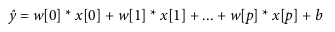

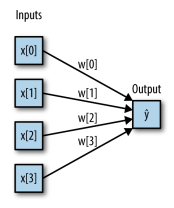

¿Les suena? Esto es un modelo lineal con 4 parámetros!

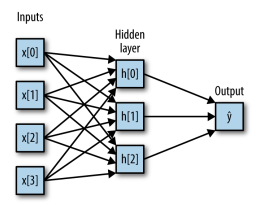

Hasta aquí es un modelo lineal un poquito más complejo, con términos que implican las combinaciones de varios parámetros.


Para hacer este modelo más potente hay que añadir un extra de computación.

Después de obtener computacionalmente la primera serie lineal para cada *hidden unit*, se le aplica una función no lineal al resultado (la función de activación).

Las funciones más comunes son ReLu, sigmoidea y tangente hiperbólica:


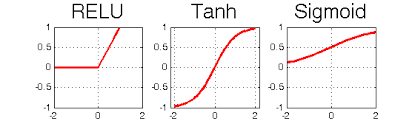

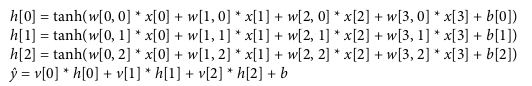

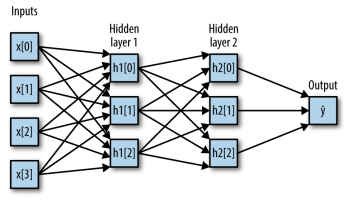

### Paquetes necesarios para Neural networks

### Pytorch
Basado en la librería Torch, PyTorch es uno de los paquetes más populares para deep learning.

Pueden explorar los [tutoriales](https://pytorch.org/tutorials/) y la [documentación](https://pytorch.org/docs/stable/index.html) para más detalles.

---

# Machine Learning Parte II - Curvas ROC

Una curva ROC da una representación visula entre el true positive rate (TPR) y el false positive rate (FPR)  a diferentes umbrales.

El TPR no es otra cosa más que el *Recall* y también se lo llama *sensitivity*.

$$
TPR = \frac{TP}{TP+FN}
$$

El FPR se calcula de la siguiente manera:

$$
FPR = \frac{FP}{FP+TN}
$$

La curva ROC ayuda a entender como el modelo hace el balance entre la detección de instancias positivas y evitar los falsos positivos.

El AUC, o el Area bajo la curva, es un valor que va entre 0 y 1, que da la *performancia* del modelo.

El AUC se calcula luego de generar la curva ROC ya que es el representa literalmente el área bajo la curva.


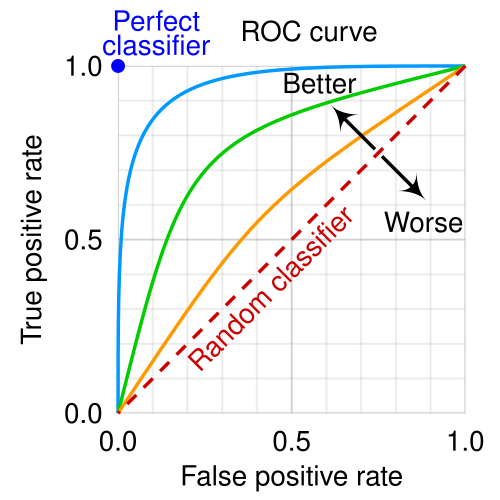